## **Libraries**

In [ ]:
pip install kagglehub

In [ ]:
import numpy as np
import pandas as pd
import kagglehub
import os

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

## **Dataset**

In [ ]:
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")
print("Path to dataset files:", path)

100%|██████████| 3.36M/3.36M [00:01<00:00, 2.48MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1


In [ ]:
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1/train.csv
/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1/features.csv
/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1/stores.csv
/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1/test.csv


## **Exploratory Data Analysis**

In [ ]:
base_path = "/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1"

train = pd.read_csv(base_path + "/train.csv")
test = pd.read_csv(base_path + "/test.csv")
features = pd.read_csv(base_path + "/features.csv")
stores = pd.read_csv(base_path + "/stores.csv")

print("Train shape:", train.shape)
print("Features shape:", features.shape)
print("Stores shape:", stores.shape)

Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)


In [ ]:
df = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")

df = df.merge(stores, on="Store", how="left")

print("Final dataset shape:", df.shape)
df.head()

Final dataset shape: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421570 n

In [ ]:
weekly_sales = df.groupby("Date")["Weekly_Sales"].sum().reset_index()

weekly_sales = weekly_sales.sort_values("Date")

weekly_sales.head()

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


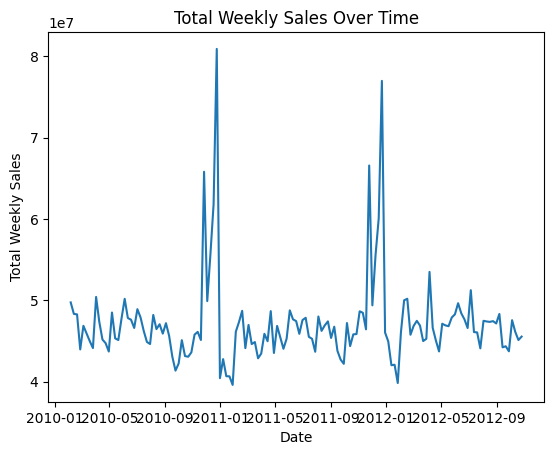

Weekly Sales Summary

Total weeks: 143
Mean weekly sales: 47,113,419.49
Median weekly sales: 46,243,899.58
Min weekly sales: 39,599,852.99
Max weekly sales: 80,931,415.60
Standard deviation: 5,444,206.20

Top 5 sales spikes:
         Date  Weekly_Sales
46 2010-12-24   80931415.60
98 2011-12-23   76998241.31
94 2011-11-25   66593605.26
42 2010-11-26   65821003.24
45 2010-12-17   61820799.85


In [ ]:
plt.plot(weekly_sales["Date"], weekly_sales["Weekly_Sales"])
plt.title("Total Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.show()

print("Weekly Sales Summary\n")
print(f"Total weeks: {len(weekly_sales)}")
print(f"Mean weekly sales: {weekly_sales['Weekly_Sales'].mean():,.2f}")
print(f"Median weekly sales: {weekly_sales['Weekly_Sales'].median():,.2f}")
print(f"Min weekly sales: {weekly_sales['Weekly_Sales'].min():,.2f}")
print(f"Max weekly sales: {weekly_sales['Weekly_Sales'].max():,.2f}")
print(f"Standard deviation: {weekly_sales['Weekly_Sales'].std():,.2f}")

top_spikes = weekly_sales.sort_values("Weekly_Sales", ascending=False).head(5)
print("\nTop 5 sales spikes:")
print(top_spikes[["Date","Weekly_Sales"]])


The dataset contains 143 weeks of total weekly sales across all stores and departments. The mean weekly sales is approximately 47.1 million, with a median of 46.2 million, indicating a relatively symmetric distribution. Sales fluctuate between a minimum of 39.6 million and a maximum of 80.9 million, with a standard deviation of 5.4 million, showing notable variation.

The top 5 sales spikes correspond to the holiday season, particularly Thanksgiving and Christmas, with the highest week on 2010-12-24 reaching 80.9 million in sales. Other spikes also occur around late November and December of 2010–2011, confirming strong seasonal effects during the year-end holiday period.

The line plot above visualizes this trend, showing a general upward trend with two prominent spikes per year, which are likely holiday-driven.

In [ ]:
decomposition = seasonal_decompose(
    weekly_sales["Weekly_Sales"],
    model="additive",
    period=52
)

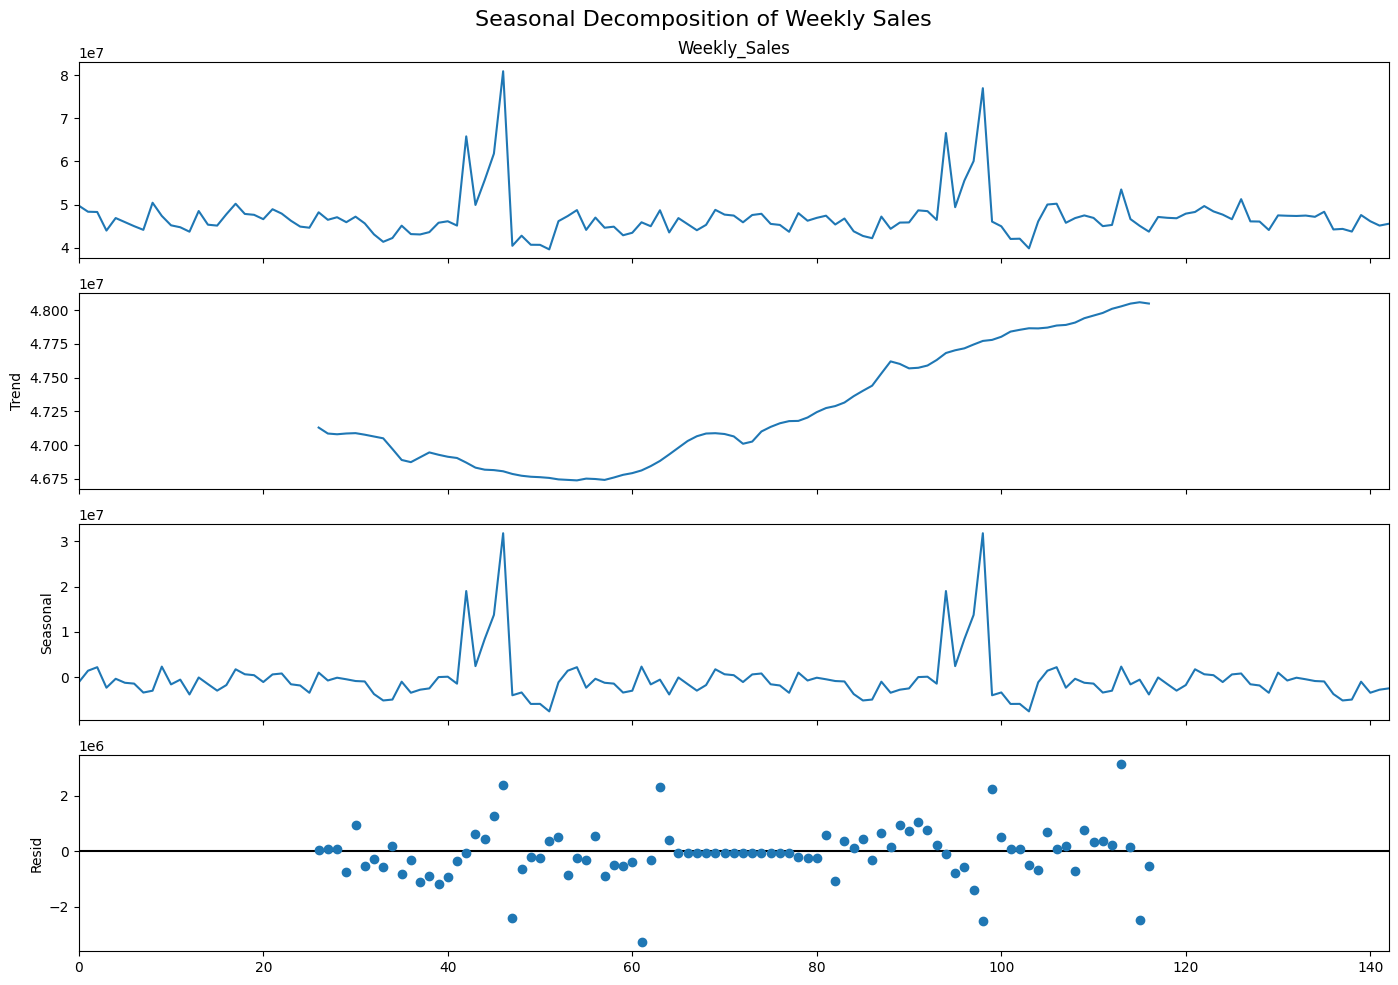

========== Seasonal Decomposition Summary ==========

Trend Component:
  Mean: 47,257,073.00
  Min: 46,739,591.28
  Max: 48,058,332.56

Seasonal Component:
  Mean: -332,527.63
  Min: -7,519,309.44
  Max: 31,750,438.52

Residual Component:
  Mean: -75,057.64
  Std Dev: 938,840.25

Overall Weekly Sales:
  Mean: 47,113,419.49
  Std Dev: 5,444,206.20


In [ ]:
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Seasonal Decomposition of Weekly Sales", fontsize=16)
plt.tight_layout()
plt.show()

trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal
residual = decomposition.resid.dropna()

print("========== Seasonal Decomposition Summary ==========\n")

print("Trend Component:")
print(f"  Mean: {trend.mean():,.2f}")
print(f"  Min: {trend.min():,.2f}")
print(f"  Max: {trend.max():,.2f}")

print("\nSeasonal Component:")
print(f"  Mean: {seasonal.mean():,.2f}")
print(f"  Min: {seasonal.min():,.2f}")
print(f"  Max: {seasonal.max():,.2f}")

print("\nResidual Component:")
print(f"  Mean: {residual.mean():,.2f}")
print(f"  Std Dev: {residual.std():,.2f}")

print("\nOverall Weekly Sales:")
print(f"  Mean: {weekly_sales['Weekly_Sales'].mean():,.2f}")
print(f"  Std Dev: {weekly_sales['Weekly_Sales'].std():,.2f}")

The seasonal decomposition of total weekly sales shows three distinct components: trend, seasonality, and residuals.

Trend Component: The mean weekly sales trend is approximately 47.26 million, ranging from 46.74 million to 48.06 million. This indicates a relatively stable upward trend over the two-year period.

Seasonal Component: The seasonal fluctuations have a mean close to zero (-0.33 million) but a wide range from -7.52 million to 31.75 million, capturing the large spikes during holiday seasons such as Thanksgiving and Christmas.

Residual Component: The residuals, representing noise or unexplained variation, have a mean of approximately -0.075 million and a standard deviation of 0.94 million, indicating that most variation in weekly sales is well explained by the trend and seasonal patterns.

Overall, the mean weekly sales across the period is 47.11 million with a standard deviation of 5.44 million, consistent with the pre-decomposition summary. The decomposition confirms strong yearly seasonality and relatively stable long-term trends, which can now inform the creation of lag features, rolling averages, and other time-based predictors for regression models

## **Feature Engineering**

In [ ]:
data = weekly_sales.copy()

data["Weekly_Sales_Log"] = np.log1p(data["Weekly_Sales"])

### **Time based Features**

In [ ]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.isocalendar().week
data["Trend"] = np.arange(len(data))
data["Quarter"] = data["Date"].dt.quarter

### **Seasonality**

In [ ]:
data["Week_sin"] = np.sin(2 * np.pi * data["Week"] / 52)
data["Week_cos"] = np.cos(2 * np.pi * data["Week"] / 52)
data["Month_sin"] = np.sin(2 * np.pi * data["Month"] / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Month"] / 12)
data["Quarter_sin"] = np.sin(2 * np.pi * data["Quarter"] / 4)
data["Quarter_cos"] = np.cos(2 * np.pi * data["Quarter"] / 4)
data["DayOfWeek"] = data["Date"].dt.dayofweek
data["DayOfWeek_sin"] = np.sin(2 * np.pi * data["DayOfWeek"] / 7)
data["DayOfWeek_cos"] = np.cos(2 * np.pi * data["DayOfWeek"] / 7)

### **Lag Features**

In [ ]:
data["Lag_1"] = data["Weekly_Sales_Log"].shift(1)
data["Lag_4"] = data["Weekly_Sales_Log"].shift(4)
data["Lag_8"] = data["Weekly_Sales_Log"].shift(8)
data["Lag_13"] = data["Weekly_Sales_Log"].shift(13)
data["Lag_26"] = data["Weekly_Sales_Log"].shift(26)
data["Lag_52"] = data["Weekly_Sales_Log"].shift(52)

### **Rolling Statistics**

In [ ]:
data["RollingMean_4"] = data["Weekly_Sales_Log"].shift(1).rolling(window=4).mean()
data["RollingStd_4"] = data["Weekly_Sales_Log"].shift(1).rolling(window=4).std()
data["RollingMean_8"] = data["Weekly_Sales_Log"].shift(1).rolling(window=8).mean()
data["RollingStd_8"] = data["Weekly_Sales_Log"].shift(1).rolling(window=8).std()
data["RollingMean_13"] = data["Weekly_Sales_Log"].shift(1).rolling(window=13).mean()
data["RollingStd_13"] = data["Weekly_Sales_Log"].shift(1).rolling(window=13).std()
data["RollingMean_26"] = data["Weekly_Sales_Log"].shift(1).rolling(window=26).mean()
data["RollingStd_26"] = data["Weekly_Sales_Log"].shift(1).rolling(window=26).std()
data["RollingMean_52"] = data["Weekly_Sales_Log"].shift(1).rolling(window=52).mean()

data["RollingTrend_4"] = data["Weekly_Sales_Log"].shift(1).rolling(4).apply(lambda x: np.polyfit(np.arange(4), x, 1)[0])
data["RollingTrend_8"] = data["Weekly_Sales_Log"].shift(1).rolling(8).apply(lambda x: np.polyfit(np.arange(8), x, 1)[0])
data["RollingTrend_13"] = data["Weekly_Sales_Log"].shift(1).rolling(13).apply(lambda x: np.polyfit(np.arange(13), x, 1)[0])

### **Year-over-Year Difference**

In [ ]:
data["YoY_Diff"] = data["Weekly_Sales_Log"] - data["Lag_52"]
data["YoY_Pct_Change"] = (data["Weekly_Sales_Log"] - data["Lag_52"]) / data["Lag_52"]
data["Lag1_Pct_Change"] = (data["Weekly_Sales_Log"] - data["Lag_1"]) / data["Lag_1"]

### **Momentum Features**

In [ ]:
data["Momentum_4"] = data["Weekly_Sales_Log"] - data["Lag_4"]
data["Momentum_8"] = data["Weekly_Sales_Log"] - data["Lag_8"]

### **Interacting Features**

In [ ]:
data["Lag1_x_Weekcos"] = data["Lag_1"] * data["Week_cos"]
data["Month_x_Trend"] = data["Month"] * data["Trend"]

### **Visualize Features**

In [ ]:
print("Final dataset shape:", data.shape)
print("Columns:", data.columns.tolist())
data.head()

Final dataset shape: (143, 42)
Columns: ['Date', 'Weekly_Sales', 'Weekly_Sales_Log', 'Year', 'Month', 'Week', 'Trend', 'Quarter', 'Week_sin', 'Week_cos', 'Month_sin', 'Month_cos', 'Quarter_sin', 'Quarter_cos', 'DayOfWeek', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Lag_1', 'Lag_4', 'Lag_8', 'Lag_13', 'Lag_26', 'Lag_52', 'RollingMean_4', 'RollingStd_4', 'RollingMean_8', 'RollingStd_8', 'RollingMean_13', 'RollingStd_13', 'RollingMean_26', 'RollingStd_26', 'RollingMean_52', 'RollingTrend_4', 'RollingTrend_8', 'RollingTrend_13', 'YoY_Diff', 'YoY_Pct_Change', 'Lag1_Pct_Change', 'Momentum_4', 'Momentum_8', 'Lag1_x_Weekcos', 'Month_x_Trend']


,Date,Weekly_Sales,Weekly_Sales_Log,Year,Month,Week,Trend,Quarter,Week_sin,Week_cos,...,RollingTrend_4,RollingTrend_8,RollingTrend_13,YoY_Diff,YoY_Pct_Change,Lag1_Pct_Change,Momentum_4,Momentum_8,Lag1_x_Weekcos,Month_x_Trend
0,2010-02-05,49750740.50,17.722536,2010,2,5,0,1,0.568065,0.822984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0
1,2010-02-12,48336677.63,17.693701,2010,2,6,1,1,0.663123,0.748511,...,NaN,NaN,NaN,NaN,NaN,-0.001627,NaN,NaN,13.265509,2
2,2010-02-19,48276993.78,17.692466,2010,2,7,2,1,0.748511,0.663123,...,NaN,NaN,NaN,NaN,NaN,-0.000070,NaN,NaN,11.733094,4
3,2010-02-26,43968571.13,17.598986,2010,2,8,3,1,0.822984,0.568065,...,NaN,NaN,NaN,NaN,NaN,-0.005284,NaN,NaN,10.050466,6
4,2010-03-05,46871470.30,17.662920,2010,3,9,4,1,0.885456,0.464723,...,-0.037189,NaN,NaN,NaN,NaN,0.003633,-0.059616,NaN,8.178656,12


To enhance the predictive power of our models, we engineered a comprehensive set of time-series features from the weekly sales data. First, we applied a logarithmic transformation to stabilize variance and reduce the impact of extreme values. We then created structured time-based features, including year, month, week number, and a continuous trend index to help the model learn long-term growth patterns. To capture seasonality more effectively, we encoded the week of the year using sine and cosine transformations, allowing the model to understand cyclical behavior across annual periods.

In addition, we generated multiple lag features on the log-transformed sales (1, 2, 4, and 52 weeks) to provide short-term memory and yearly recurrence patterns. Rolling statistics, such as 4-week and 12-week rolling means and standard deviations, were added to smooth short-term fluctuations and capture local volatility. We also introduced momentum and year-over-year difference features to reflect recent growth and comparative seasonal changes. Together, these engineered features enable tree-based models to effectively capture trend, seasonality, momentum, and volatility in weekly sales forecasting.

The NaN values in the dataset appear as a result of creating lag and rolling features. These features rely on historical data, such as the previous week’s sales, the average sales of the past 4 weeks, or the sales from the same week in the previous year. For the earliest weeks in the dataset, there is not enough past data to compute these features, which naturally leads to missing values (NaNs) in the corresponding columns. These NaNs indicate the absence of sufficient historical information for those time-based calculations.

## **Data splitting**

In [ ]:
split_ratio = 0.8
split_idx = int(len(data) * split_ratio)

train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

X_train = train_data.drop(columns=["Date", "Weekly_Sales", "Weekly_Sales_Log"])
y_train = train_data["Weekly_Sales_Log"]

X_test = test_data.drop(columns=["Date", "Weekly_Sales", "Weekly_Sales_Log"])
y_test = test_data["Weekly_Sales"]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)

Train shape: (114, 39) (114,)
Test shape : (29, 39) (29,)


In [ ]:
print("\nTrain date range: {} to {}".format(train_data['Date'].min().date(), train_data['Date'].max().date()))
print("Test date range : {} to {}".format(test_data['Date'].min().date(), test_data['Date'].max().date()))

print("\nTrain head:")
print(train_data[["Date","Weekly_Sales"]].head())

print("\nTest head:")
print(test_data[["Date","Weekly_Sales"]].head())


Train date range: 2010-02-05 to 2012-04-06
Test date range : 2012-04-13 to 2012-10-26

Train head:
        Date  Weekly_Sales
0 2010-02-05   49750740.50
1 2010-02-12   48336677.63
2 2010-02-19   48276993.78
3 2010-02-26   43968571.13
4 2010-03-05   46871470.30

Test head:
          Date  Weekly_Sales
114 2012-04-13   46629261.41
115 2012-04-20   45072529.78
116 2012-04-27   43716798.89
117 2012-05-04   47124197.93
118 2012-05-11   46925878.99


To ensure realistic forecasting and prevent information leakage, the dataset was split chronologically. The first 80% of the timeline, from 2010-02-05 to 2012-04-06, was used as the training set, while the last 20%, from 2012-04-13 to 2012-10-26, was reserved for testing. This time-aware split preserves the sequential order of the data, allowing models to learn patterns from historical sales and apply them to future weeks. The train and test sets maintain the weekly frequency, ensuring that each week in the test set is immediately consecutive to the last week in the training set.

## **Regression Models**

### **Random Forest**

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=800,
    max_depth=25,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=800, n_jobs=-1,
                      random_state=42)

In [ ]:
y_pred_log = rf_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

Random Forest Evaluation
MAE : 795,578.85
MSE : 1,199,849,860,135.88
RMSE: 1,095,376.58
R²  : 59.95%


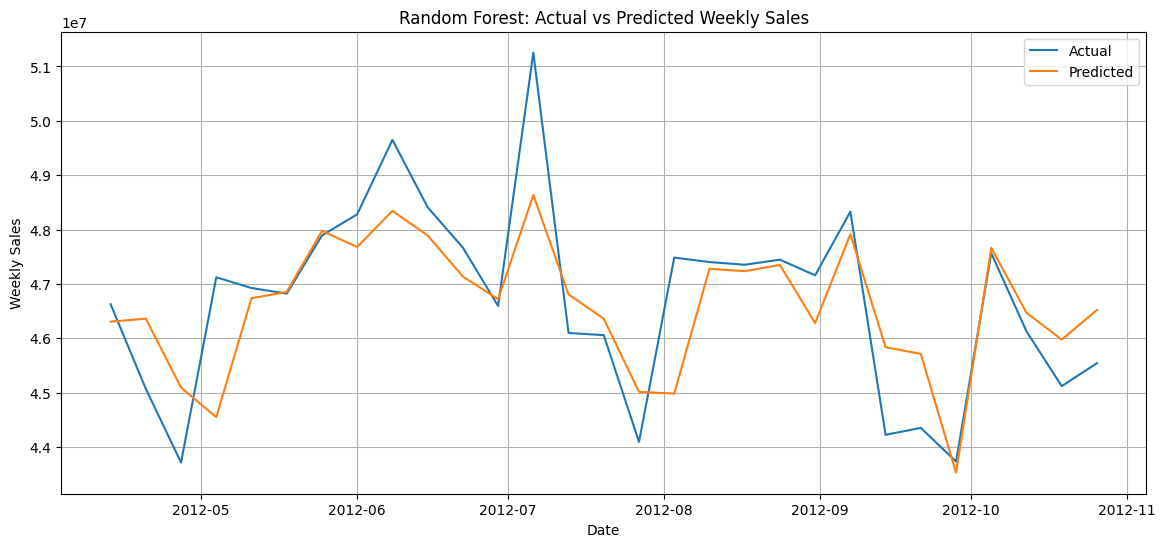

In [ ]:
mae_rf = mean_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print("Random Forest Evaluation")
print(f"MAE : {mae_rf:,.2f}")
print(f"MSE : {mse_rf:,.2f}")
print(f"RMSE: {rmse_rf:,.2f}")
print(f"R²  : {r2_rf*100:.2f}%")

plt.figure(figsize=(14,6))
plt.plot(test_data["Date"], y_test, label="Actual")
plt.plot(test_data["Date"], y_pred, label="Predicted")
plt.title("Random Forest: Actual vs Predicted Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False).head(10)

,0
Momentum_8,0.353736
Momentum_4,0.187240
Lag1_Pct_Change,0.098177
Week,0.035693
Lag_52,0.031783
Lag_1,0.025422
Lag_4,0.018041
Month_x_Trend,0.016157
Lag_26,0.015664
Lag1_x_Weekcos,0.013639


For the Random Forest model, we used the full set of engineered features, including time-based, lag, rolling, and momentum features. The model achieved a MAE of 795,579, an RMSE of 1,095,377, and an R² of 59.95%, showing strong predictive performance. Feature importance analysis revealed that Momentum_8, Momentum_4, and Lag1_Pct_Change were the most influential features, highlighting that both recent trends and short-term changes are critical for predicting weekly sales. Other important contributors included Week, Lag_52, and Lag_1, reflecting the importance of seasonal patterns and past sales in the forecast. Overall, Random Forest provides a robust and interpretable baseline for weekly sales forecasting on this dataset.

### **XGBoost**

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred_log = xgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

XGBoost Evaluation
MAE : 495,233.15
MSE : 505,576,499,615.21
RMSE: 711,039.03
R²  : 83.12%


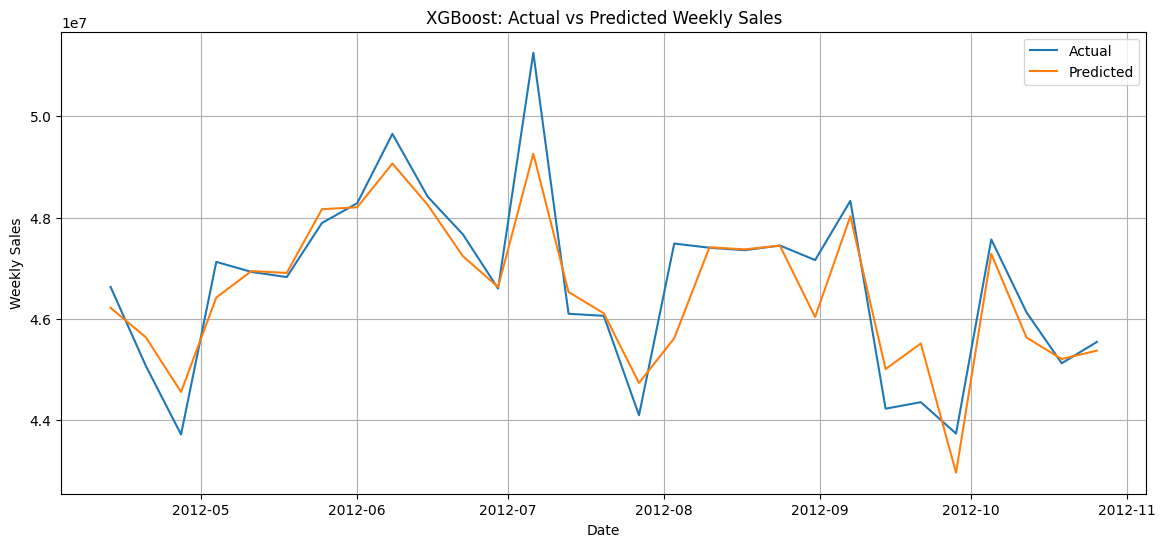

In [ ]:
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)

print("XGBoost Evaluation")
print(f"MAE : {mae_xgb:,.2f}")
print(f"MSE : {mse_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"R²  : {r2_xgb*100:.2f}%")

plt.figure(figsize=(14,6))
plt.plot(test_data["Date"], y_test, label="Actual")
plt.plot(test_data["Date"], y_pred, label="Predicted")
plt.title("XGBoost: Actual vs Predicted Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False).head(10)

,0
Momentum_8,0.460788
Momentum_4,0.120480
Lag1_Pct_Change,0.076003
RollingStd_4,0.031107
Lag1_x_Weekcos,0.023644
Week,0.022752
Lag_1,0.020441
RollingStd_13,0.018172
Week_cos,0.016998
Quarter_sin,0.016967


For the XGBoost model, we trained using the same engineered features as the other models and achieved a MAE of 495,233, an RMSE of 711,039, and an R² of 83.12%, demonstrating strong predictive performance and improved accuracy over Random Forest and LightGBM. Feature importance analysis highlighted that Momentum_8, Momentum_4, and Lag1_Pct_Change were the most influential features, showing that both recent trends and short-term percentage changes are key drivers of weekly sales. Other important contributors included RollingStd_4, Lag1_x_Weekcos, Week, and Lag_1, indicating the model effectively captures both short-term fluctuations and seasonal patterns in the data.

### **LightGBM**

In [ ]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 36
[LightGBM] [Info] Start training from score 17.663773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, max_depth=6,
              n_estimators=600, random_state=42, subsample=0.8)

In [ ]:
y_pred_log = lgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

LightGBM
MAE : 999,726.35
MSE : 1,632,196,181,629.87
RMSE: 1,277,574.34
R²  : 45.51%


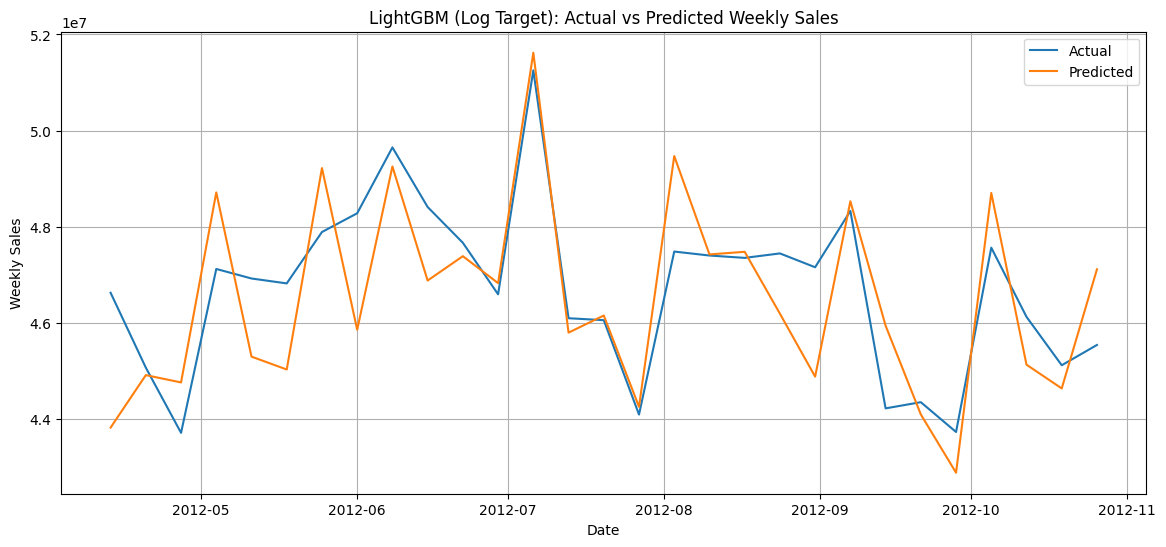

In [ ]:
mae_lgb = mean_absolute_error(y_test, y_pred)
mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print("LightGBM")
print(f"MAE : {mae_lgb:,.2f}")
print(f"MSE : {mse_lgb:,.2f}")
print(f"RMSE: {rmse_lgb:,.2f}")
print(f"R²  : {r2_lgb*100:.2f}%")

plt.figure(figsize=(14,6))
plt.plot(test_data["Date"], y_test, label="Actual")
plt.plot(test_data["Date"], y_pred, label="Predicted")
plt.title("LightGBM (Log Target): Actual vs Predicted Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False).head(10)

,0
Momentum_4,226
RollingTrend_4,189
Momentum_8,151
Lag1_Pct_Change,141
Lag_1,138
Lag_13,112
Lag1_x_Weekcos,90
RollingStd_13,84
RollingTrend_13,83
Lag_26,77


In [ ]:
feat_importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
top_features = feat_importances.head(10).index
X_train_sel = X_train[top_features]
X_test_sel = X_test[top_features]

In [ ]:
lgb_fs_model = lgb.LGBMRegressor(
    n_estimators=600,
    learning_rate=0.01,
    max_depth=6,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)
lgb_fs_model.fit(X_train_sel, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 10
[LightGBM] [Info] Start training from score 17.663773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=6,
              n_estimators=600, random_state=42, subsample=0.7)

In [ ]:
y_pred_fs_log = lgb_fs_model.predict(X_test_sel)
y_pred_fs = np.expm1(y_pred_fs_log)

LightGBM (Feature-Selected) Evaluation
MAE : 872,319.05
MSE : 1,316,197,587,982.69
RMSE: 1,147,256.55
R²  : 56.06%


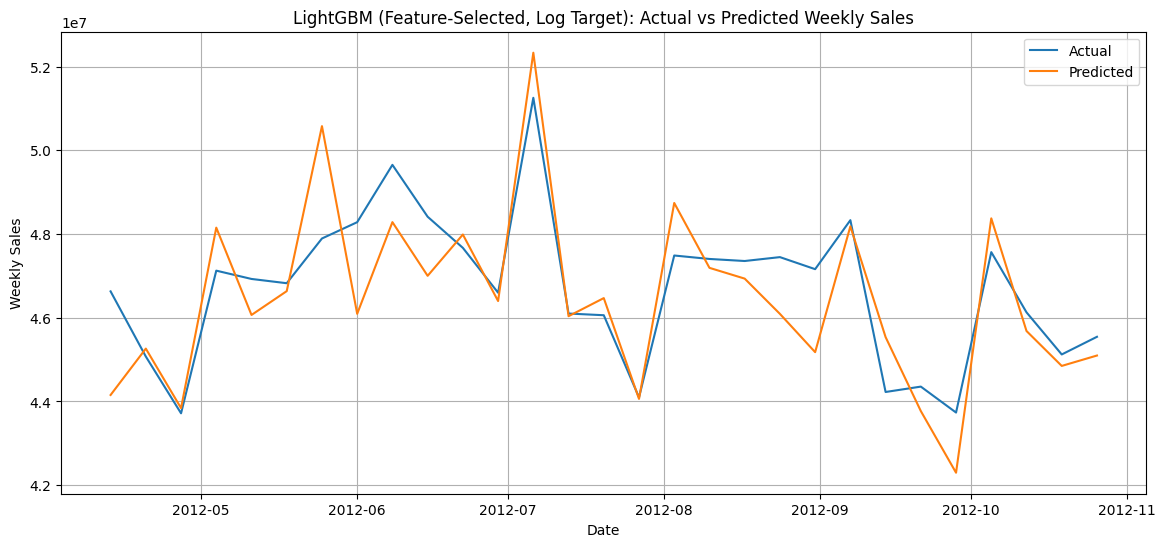

In [ ]:
mae_fs = mean_absolute_error(y_test, y_pred_fs)
mse_fs = mean_squared_error(y_test, y_pred_fs)
rmse_fs = np.sqrt(mse_fs)
r2_fs = r2_score(y_test, y_pred_fs)

print("LightGBM (Feature-Selected) Evaluation")
print(f"MAE : {mae_fs:,.2f}")
print(f"MSE : {mse_fs:,.2f}")
print(f"RMSE: {rmse_fs:,.2f}")
print(f"R²  : {r2_fs*100:.2f}%")

plt.figure(figsize=(14,6))
plt.plot(test_data["Date"].reset_index(drop=True), y_test.reset_index(drop=True), label="Actual")
plt.plot(test_data["Date"], y_pred_fs, label="Predicted")
plt.title("LightGBM (Feature-Selected, Log Target): Actual vs Predicted Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

For LightGBM, we observed that using the full engineered feature set caused the model to overfit due to the relatively small size of the weekly dataset. To address this, we performed feature selection, picking the top 10 most important features based on the original LightGBM feature importances. Retraining the model on this reduced set led to a significant improvement in performance: the MAE decreased from 999,726 to 872,319, RMSE dropped from 1,277,574 to 1,147,257, and R² increased from 45.51% to 56.06%. This demonstrates that focusing on the most relevant features helps LightGBM generalize better and reduces overfitting while maintaining the predictive power of the model.

## **Comparison Analysis**

| Model                       | MAE        | MSE                  | RMSE         | R² (%) |
| --------------------------- | ---------- | -------------------- | ------------ | ------ |
| Random Forest               | 795,578.85 | 1,199,849,860,135.88 | 1,095,376.58 | 59.95  |
| XGBoost                     | 495,233.15 | 505,576,499,615.21   | 711,039.03   | 83.12  |
| LightGBM (Feature-Selected) | 872,319.05 | 1,316,197,587,982.69 | 1,147,256.55 | 56.06  |


Across our three models — Random Forest, XGBoost, and LightGBM (feature-selected) — we can observe clear differences in predictive performance. XGBoost outperformed the others, achieving the highest R² of 83.12%, along with the lowest MAE (495,233) and RMSE (711,039), demonstrating its superior ability to capture both short-term trends and seasonal patterns in weekly sales. Random Forest performed well with an R² of 59.95%, MAE of 795,579, and RMSE of 1,095,377, highlighting the importance of momentum and lag-based features like Momentum_8, Momentum_4, and Lag1_Pct_Change. LightGBM with feature selection improved over the original model, reaching an R² of 56.06%, MAE of 872,319, and RMSE of 1,147,257, but still lagged behind XGBoost, indicating that its regularization and boosting structure was less effective on this dataset with the selected features.

From a feature perspective, all models consistently emphasized momentum features (Momentum_4, Momentum_8), short-term lag effects, and weekly/seasonal components, showing that capturing both recent trends and cyclic patterns is key to accurate weekly sales forecasting. Overall, XGBoost is the strongest model, while Random Forest and LightGBM remain robust alternatives depending on the trade-offs between interpretability and computational cost.